# Beijing Air Quality Forecasting Starter Notebook

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [14]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [17]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [18]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [19]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [20]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [21]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
y = train['pm2.5']  # Replace with actual column name
X = X = train.drop(columns=['pm2.5', 'No'])  # Drop target from features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Feature Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Train-validation split after scaling
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Define an optimized LSTM model with scaling
model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, activation='tanh', return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]  # RMSE metric
)

# Callbacks to improve training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Display the model summary
model.summary()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


614/614 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0220 - root_mean_squared_error: 0.1420 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878 - learning_rate: 0.0010
Epoch 2/20
614/614 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782 - learning_rate: 0.0010
Epoch 3/20
614/614 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766 - learning_rate: 0.0010
Epoch 4/20
614/614 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761 - learning_rate: 0.0010
Epoch 5/20
614/614 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765 - learning_rate: 0.0010
Epoch 6/20
614/614 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0061 - root_mean_squared_er

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 128)              │          37,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,173,637 (4.48 MB)

 Trainable params: 390,913 (1.49 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 781,828 (2.98 MB)

In [26]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 8328.3867 - root_mean_squared_error: 90.3681
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 5570.8145 - root_mean_squared_error: 74.6261
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 5492.4468 - root_mean_squared_error: 74.0952
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 5419.4062 - root_mean_squared_error: 73.6065
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 5392.4463 - root_mean_squared_error: 73.4204
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 5349.0439 - root_mean_squared_error: 73.1256
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 5287.6929 - root_mean_squared_error: 72.7026
Epoch 8/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 5238.1553 - root_mean_squared_error: 72.3586
Epoch 9/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 5303.0435 - root_mean_squared_error: 72.8126
Epoch 10/10
767/767 ━━━━━━━━━━━━━━━━━━

767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


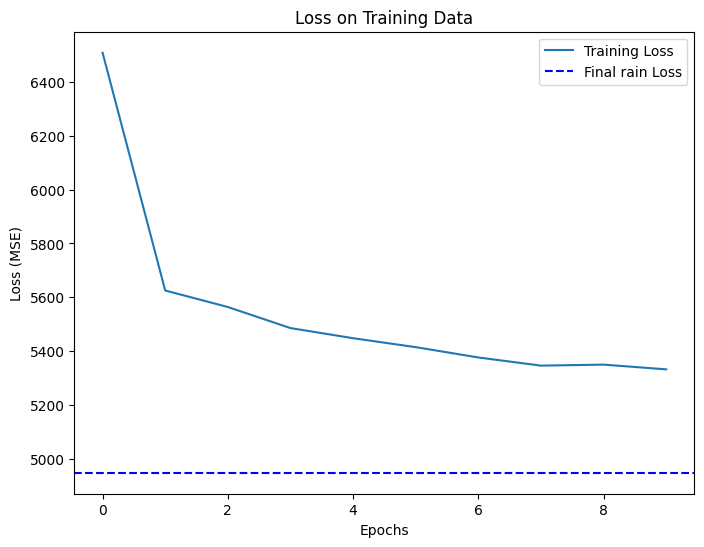

Final Training Loss (MSE): 4947.823746792084


In [27]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [28]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
